# Part 1: Optimal Transport and Wasserstein Distances

The goal of this first practical session is to introduce computational optimal transport (OT) in Python. You will familiarize yourself with OT by:
1. using the Python library POT (Python Optimal Transport),
2. coding Sinkhorn's algorithm.

In the second practical session, we will use optimal transport as a nice geometrical tool in machine learning.

You first need to install the package POT:
* Install with pip: ```bash pip install pot```
* Install with conda: ```bash conda install -c conda-forge pot ```

In [1]:
# Check your installation by importing POT
import ot

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Solving Exact OT: Linear Programming

### Reminders on Optimal Transport

Optimal Transport is a theory that allows us to compare two (weighted) points clouds $(X, a)$ and $(Y, b)$, where $X \in \mathbb{R}^{n \times d}$ and $Y \in \mathbb{R}^{m \times d}$ are the locations of the $n$ (resp. $m$) points in dimension $d$, and $a \in \mathbb{R}^n$, $b \in \mathbb{R}^m$ are the weights. We ask that the total weights sum to one, i.e. $\sum_{i=1}^n a_i = \sum_{j=1}^m b_j = 1$.

The basic idea of Optimal Transport is to "transport" the mass located at points $X$ to the mass located at points $Y$.

Let us denote by $\mathcal{U}(a,b) = \left\{ P \in \mathbb{R}^{n \times m} \,|\, P \geq 0, \sum_{j=1}^m P_{ij} = a_i, \sum_{i=1}^n P_{ij} = b_j\right\}$ the set of admissible transport plans.

If $P \in \mathcal{U}(a,b)$, the quantity $P_{ij} \geq 0$ should be regarded as the mass transported from point $X_i$ to point $Y_j$. For this reason, it is called a *transport plan*.

We will also consider a *cost matrix* $C \in \mathbb{R}^{n \times m}$. The quantity $C_{ij}$ should be regarded as the cost paid for transporting one unit of mass from $X_i$ to $Y_j$. This cost is usually computed using the positions $X_i$ and $Y_j$, for example $C_{ij} = \|X_i - Y_j\|$ or $C_{ij} = \|X_i - Y_j\|^2$.

Then transporting mass according to $P \in \mathcal{U}(a,b)$ has a total cost of $\sum_{ij} P_{ij} C_{ij}$.

In "Optimal Transport", there is the word _Optimal_. Indeed, we want to find a transport plan $P \in \mathcal{U}(a,b)$ that will minimize its total cost. In other words, we want to solve
$$
    \min_{P \in \mathcal{U}(a,b)} \sum_{ij} C_{ij }P_{ij}.
$$

This problem is a Linear Program: the objective function is linear in the variable $P$, and the constraints are linear in $P$. We can thus solve this problem using classical Linear Programming algorithms, such as the simplex algorithm.

If $P^*$ is a solution to the Optimal Transport problem, we will say that $P^*$ is an optimal transport plan between $(X, a)$ and $(Y, b)$, and that $\sum_{ij} P^*_{ij} C_{ij}$ is the optimal transport distance between $(X, a)$ and $(Y, b)$: it is the minimal amount of "energy" that is necessary to transport the initial mass located at points $X$ to the target mass lcoated at points $Y$.

### Computing Optimal "Croissant" Transport using POT

We will solve the Bakery/Cafés problem of transporting croissants from a number of Bakeries to Cafés in Palaiseau.

We use fictional positions, production and sale numbers (that both sum to the same value).

We have acess to the position of Bakeries $X \in \mathbb{R}^{8 \times 2}$ and their respective production $a \in \mathbb{R}^8$ which describe the source point cloud. The Cafés where the croissants are sold are defined by their position $Y \in \mathbb{R}^{5 \times 2}$ and $b \in \mathbb{R}^{5}$.

In [6]:
# Load the data
import pickle

with open('data/croissants.pickle', 'rb') as file:
    croissants = pickle.load(file)

X = croissants['bakery_pos']
a = croissants['bakery_prod']
Y = croissants['cafe_pos']
b = croissants['cafe_prod']

print('Bakery productions =', a)
print('Café sales =', b)
print('Total number of croissants =', a.sum())

Bakery productions = [31. 48. 82. 30. 40. 48. 89. 73.]
Café sales = [82. 88. 92. 88. 91.]
Total number of croissants = 441.0


In [7]:
a = a/ a.sum()
b = b/ b.sum()

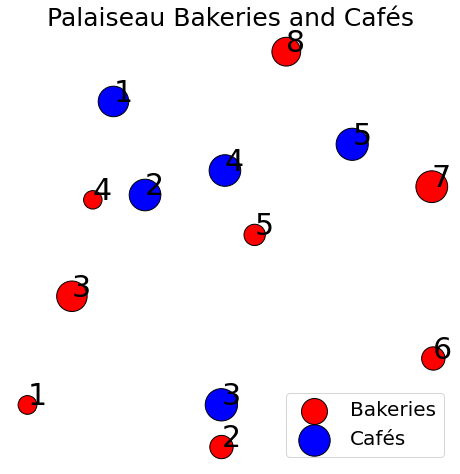

In [8]:
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], s=5000*a, c='r', edgecolors='k', label='Bakeries')
plt.scatter(Y[:,0], Y[:,1], s=5000*b, c='b', edgecolors='k', label='Cafés')
for i in range(np.shape(X)[0]):
    plt.annotate(str(i+1), (X[i,0], X[i,1]),fontsize=30,color='black')
for i in range(np.shape(Y)[0]):
    plt.annotate(str(i+1), (Y[i,0], Y[i,1]),fontsize=30,color='black')
plt.legend(fontsize=20)
plt.axis('off')
plt.title('Palaiseau Bakeries and Cafés', fontsize=25)
plt.show()

Let us now compute the cost matrix $C \in \mathbb{R}^{n \times m}$. Here, we will use two different costs: $\ell_1$ and $\ell_2$ costs.

In [9]:
C_1 = np.zeros((8,5))
C_2 = np.zeros((8,5))
for i in range(8):
    for j in range(5):
        C_1[i,j] = np.linalg.norm(X[i]-Y[j], ord=1)
        C_2[i,j] = np.linalg.norm(X[i]-Y[j])

We can now compute the Optimal Transport plan to transport the croissants from the bakeries to the cafés, for the two different costs.

In [10]:
optimal_plan_1 = ot.emd(a, b, C_1)
print(optimal_plan_1)
optimal_cost_1 = np.sum(optimal_plan_1*C_1)
print('1-Wasserstein distance =', optimal_cost_1)
print('')

optimal_plan_2 = ot.emd(a, b, C_2)
print(optimal_plan_2)
optimal_cost_2 = np.sum(optimal_plan_2*C_2)
print('2-Wasserstein distance =', np.sqrt(optimal_cost_2))

[[0.07029478 0.         0.         0.         0.        ]
 [0.         0.         0.10884354 0.         0.        ]
 [0.05442177 0.13151927 0.         0.         0.        ]
 [0.         0.06802721 0.         0.         0.        ]
 [0.         0.         0.         0.09070295 0.        ]
 [0.         0.         0.09977324 0.00453515 0.00453515]
 [0.         0.         0.         0.         0.20181406]
 [0.06122449 0.         0.         0.10430839 0.        ]]
1-Wasserstein distance = 177.28420815406034

[[0.         0.07029478 0.         0.         0.        ]
 [0.         0.         0.10884354 0.         0.        ]
 [0.05668934 0.1292517  0.         0.         0.        ]
 [0.06802721 0.         0.         0.         0.        ]
 [0.         0.         0.         0.09070295 0.        ]
 [0.         0.         0.09977324 0.00453515 0.00453515]
 [0.         0.         0.         0.         0.20181406]
 [0.06122449 0.         0.         0.10430839 0.        ]]
2-Wasserstein distance = 

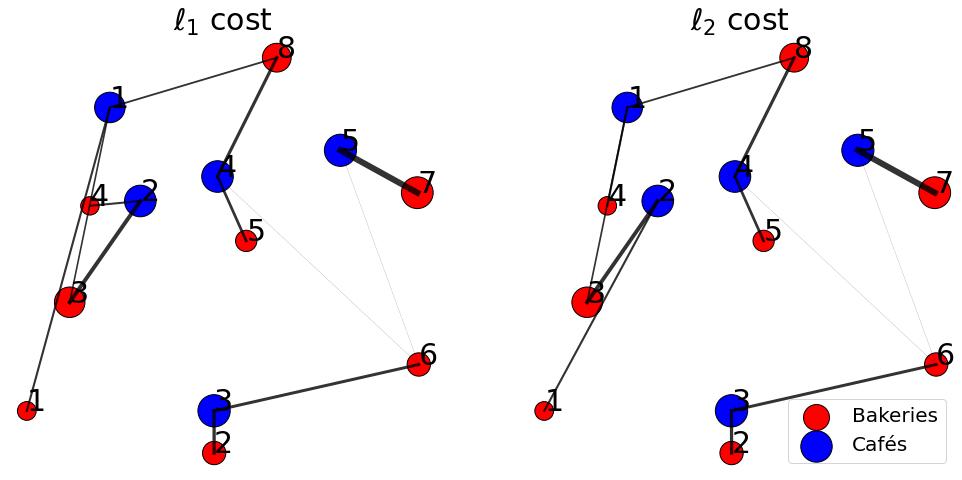

In [11]:
fig = plt.figure(figsize=(17,8))

ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:,0], X[:,1], s=5000*a, c='r', edgecolors='k', label='Bakeries')
ax.scatter(Y[:,0], Y[:,1], s=5000*b, c='b', edgecolors='k', label='Cafés')
for i in range(np.shape(X)[0]):
    plt.annotate(str(i+1), (X[i,0], X[i,1]),fontsize=30,color='black')
for i in range(np.shape(Y)[0]):
    plt.annotate(str(i+1), (Y[i,0], Y[i,1]),fontsize=30,color='black')
for i in range(8):
    for j in range(5):
        ax.plot([X[i,0], Y[j,0]], [X[i,1], Y[j,1]], c='k', lw=30*optimal_plan_1[i,j], alpha=0.8)
ax.axis('off')
ax.set_title('$\ell_1$ cost', fontsize=30)

ax = fig.add_subplot(1, 2, 2)
ax.scatter(X[:,0], X[:,1], s=5000*a, c='r', edgecolors='k', label='Bakeries')
ax.scatter(Y[:,0], Y[:,1], s=5000*b, c='b', edgecolors='k', label='Cafés')
for i in range(np.shape(X)[0]):
    plt.annotate(str(i+1), (X[i,0], X[i,1]),fontsize=30,color='black')
for i in range(np.shape(Y)[0]):
    plt.annotate(str(i+1), (Y[i,0], Y[i,1]),fontsize=30,color='black')
for i in range(8):
    for j in range(5):
        ax.plot([X[i,0], Y[j,0]], [X[i,1], Y[j,1]], c='k', lw=30*optimal_plan_2[i,j], alpha=0.8)
ax.axis('off')
ax.set_title('$\ell_2$ cost', fontsize=30)

plt.legend(fontsize=20)
plt.show()

## 2. Sinkhorn Algorithm for Entropy Regularized Optimal Transport

### Reminders on Sinkhorn Algorithm

In real applications, and especially in Machine Learning, we often have to deal with huge numbers of points. In this case, the linear programming algorithms which have cubic complexity will take too much time to run.

That's why in practise, among other reasons, people minimize another criterion given by
$$
    \min_{P \in \mathcal{U}(a,b)} \langle C, P \rangle + \epsilon \sum_{ij} P_{ij} [ \log(P_{ij}) - 1].
$$
When $\epsilon$ is sufficiently small, we can consider that a solution to the above problem (often refered to as "Entropy-regularized Optimal Transport") is a good approximation of a real optimal transport plan.

In order to solve this problem, one can remark that the optimality conditions imply that a solution $P_\epsilon^*$ necessarily is of the form $P_\epsilon^* = \text{diag}(u) \, K \, \text{diag}(v)$, where $K = \exp(-C/\epsilon)$ and $u,v$ are two non-negative vectors.

$P_\epsilon^*$ should verify the constraints, i.e. $P_\epsilon^* \in \mathcal{U}(a,b)$, so that
$$
    P_\epsilon^* 1_m = a \text{  and  } (P_\epsilon^*)^T 1_n = b
$$
which can be rewritten as
$$
    u \odot (Kv) = a \text{  and  } v \odot (K^T u) = b
$$

Then Sinkhorn's algorithm alternate between the resolution of these two equations, and reads
$$
    u \leftarrow \frac{a}{Kv} \text{  and  } v \leftarrow \frac{b}{K^T u}
$$

In [9]:
def sinkhorn(a, b, C, epsilon=0.1, max_iters=100,delta = 1e-4):
    """Run Sinnkhorn's algorithm"""
    
    # Compute the kernel matrix K
    K = np.exp(-C/epsilon)
    
    # Alternate projections
    v = np.ones(b.shape[0])
    err = 1
    for _ in range(max_iters):
        u = a / K.dot(v)
        v = b / K.T.dot(u)
     
#     while err > delta:
#         u = a / K.dot(v)
#         v = b / K.T.dot(u)
        
#         err = np.sum(np.abs(u * K.dot(v) - a))
#         err = err 
    
    return np.diag(u).dot(K).dot(np.diag(v))

In [10]:
sinkhorn(a, b, C_2/C_2.max(), epsilon=0.001)

array([[2.57906638e-002, 5.62054100e-002, 3.21170960e-003,
        4.44633605e-092, 0.00000000e+000],
       [3.18876861e-244, 2.62714162e-200, 2.05405070e-001,
        1.11074949e-199, 2.81964585e-286],
       [7.89188557e-002, 1.43341075e-001, 3.35938622e-056,
        4.75070059e-098, 0.00000000e+000],
       [8.12315236e-002, 1.11995113e-023, 1.07723842e-144,
        1.74619574e-126, 1.35917846e-297],
       [3.77719615e-102, 5.76136492e-075, 1.81441406e-037,
        7.06359302e-002, 4.09351920e-094],
       [0.00000000e+000, 0.00000000e+000, 1.04405144e-031,
        5.77333420e-091, 7.22975269e-002],
       [0.00000000e+000, 0.00000000e+000, 1.09734896e-149,
        1.04626095e-135, 1.34051664e-001],
       [7.33261901e-065, 1.24130622e-083, 6.78342124e-118,
        1.28910555e-001, 1.49394783e-008]])

In [11]:
optimal_plan_2

array([[0.        , 0.07029478, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.10884354, 0.        , 0.        ],
       [0.05668934, 0.1292517 , 0.        , 0.        , 0.        ],
       [0.06802721, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.09070295, 0.        ],
       [0.        , 0.        , 0.09977324, 0.00453515, 0.00453515],
       [0.        , 0.        , 0.        , 0.        , 0.20181406],
       [0.06122449, 0.        , 0.        , 0.10430839, 0.        ]])

We first show that this algorithm is consistent with classical optimal transport, using the "croissant" transport example.

In [12]:
plan_diff = []
distance_diff = []
for epsilon in np.linspace(0.01, 1, 100):
    optimal_plan_sinkhorn = sinkhorn(a, b, C_2/C_2.max(), epsilon, 1000)
    optimal_cost_sinkhorn = np.sum(optimal_plan_sinkhorn*C_2)
    plan_diff.append(np.linalg.norm(optimal_plan_sinkhorn-optimal_plan_2))
    distance_diff.append(100*np.abs(optimal_cost_sinkhorn-optimal_cost_2)/optimal_cost_2)

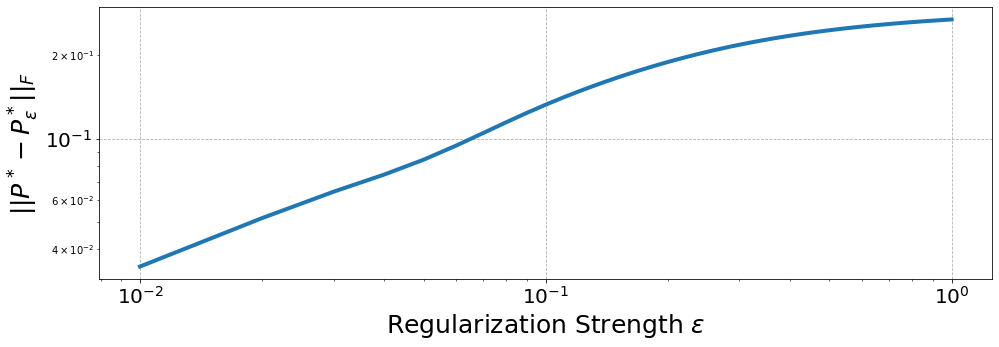

In [13]:
plt.figure(figsize=(16,5))
plt.loglog(np.linspace(0.01, 1, 100), plan_diff, lw=4)
plt.xlabel('Regularization Strength $\epsilon$', fontsize=25)
plt.ylabel('$||P^* - P_\epsilon^*||_F$', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(ls='--')
plt.show()

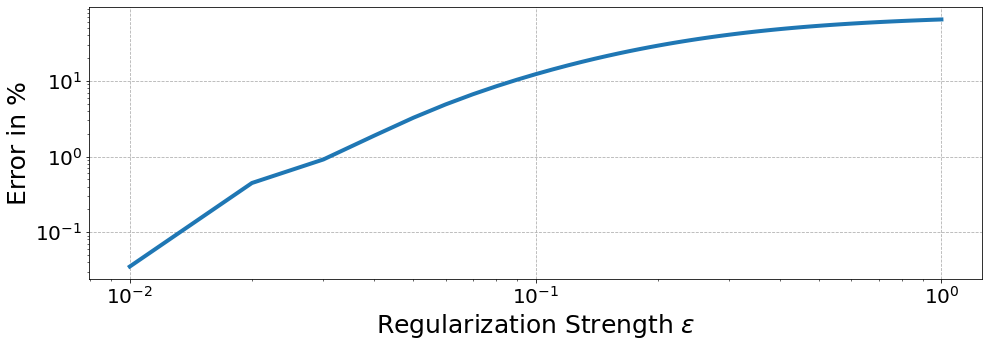

In [14]:
plt.figure(figsize=(16,5))
plt.loglog(np.linspace(0.01, 1, 100), distance_diff, lw=4)
plt.xlabel('Regularization Strength $\epsilon$', fontsize=25)
plt.ylabel('Error in %', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(ls='--')
plt.show()

Let us now compare the running time for sinkhorn and classical optimal transport algorithm on more data.

In [22]:
n = 1000
m = 1000
d = 2

X = np.random.randn(n,d)
Y = np.random.randn(m,d)

a = np.ones(n)
b = np.ones(m)

C = ((X[:, None] - Y)**2).sum(axis=2)

In [23]:
%timeit ot.emd(a,b,C)

810 µs ± 8.26 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [24]:
%timeit sinkhorn(a,b,C)

1.41 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


We see that sinkhorn is faster. What is even more interesting is that sinkhorn can be parallelerized on GPUs, giving further acceleration. Of course, Sinkhorn algorithm is not computing the exact optimal transport plan any more.

## 3. Optimal Transport in Dimension 1

In dimension $d=1$, computing OT boils down to sorting the points. You will check this fact, and discuss the influence of the regularization strength $\epsilon$.

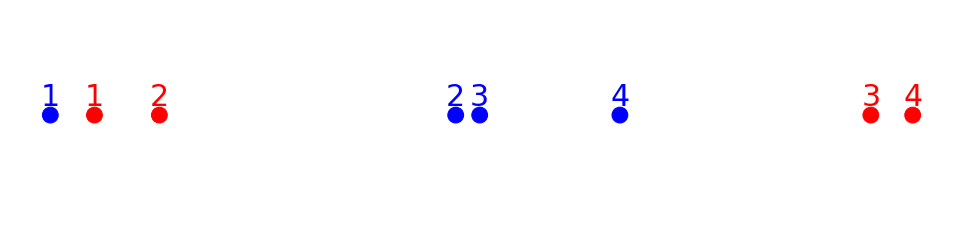

In [25]:
n = 4
m = 4
np.random.seed(49)
X = np.random.uniform(size=n)
Y = np.random.uniform(size=m)

X = np.sort(X)
Y = np.sort(Y)

a = np.ones(n) / n
# a = np.abs(np.random.randn(n)) 
# a = a / np.sum(a)
b = np.ones(m) / m

C = np.zeros((n,m))
for i in range(n):
    for j in range(m):
        C[i,j] = (X[i] - Y[j])**2

plt.figure(figsize=(17,4))
plt.scatter(X, np.zeros(n), s=1000*a, c='r')
plt.scatter(Y, np.zeros(m), s=1000*b, c='b')
for i in range(n):
    plt.gca().annotate(str(i+1), xy=(X[i],0.005), size=30, color='r', ha='center')
for j in range(m):
    plt.gca().annotate(str(j+1), xy=(Y[j],0.005), size=30, color='b', ha='center')
plt.axis('off')
plt.show()

In [26]:
optimal_plan = ot.emd(a, b, C)

optimal_plan_sinkhorn = sinkhorn(a, b, C, epsilon=1e-3, max_iters=10000)

#sort_plan = np.zeros((n,m))
#sort_plan[np.argsort(X), np.argsort(Y)] = 1.

In [27]:
optimal_plan

array([[0.25, 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.  ],
       [0.  , 0.  , 0.  , 0.25]])

In [28]:
b

array([0.25, 0.25, 0.25, 0.25])

In [29]:
optimal_plan

array([[0.25, 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.  ],
       [0.  , 0.  , 0.  , 0.25]])

In [30]:
np.round(optimal_plan_sinkhorn, 3)

array([[0.25 , 0.   , 0.   , 0.   ],
       [0.   , 0.25 , 0.   , 0.   ],
       [0.   , 0.   , 0.246, 0.004],
       [0.   , 0.   , 0.004, 0.246]])

## Wasserstein Geodesic in 1D

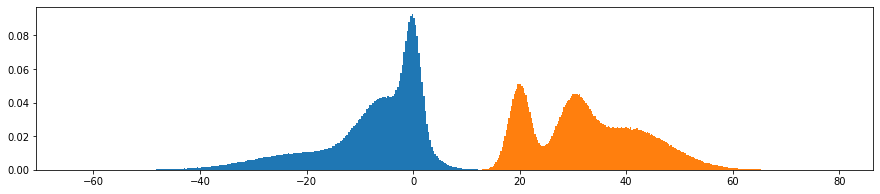

In [31]:
n = 1000000

X1 = 1.5*np.random.randn(int(n/4))
X2 = -5 + 5*np.random.randn(int(n/2))
X3 = -20 + 10*np.random.randn(int(n/4))
X = np.append(X1, X2, axis=0)
X = np.append(X, X3, axis=0)

Y1 = 40 + 8*np.random.randn(int(n/2))
Y2 = 30 + 3*np.random.randn(int(n/4))
Y3 = 20 + 2*np.random.randn(int(n/4))
Y = np.append(Y1, Y2, axis=0)
Y = np.append(Y, Y3, axis=0)

plt.figure(figsize=(15,3))
plt.hist(X, bins=300, density=True);
plt.hist(Y, bins=300, density=True);
plt.show()

In [57]:
X = np.sort(X, axis=None)
Y = np.sort(Y, axis=None)

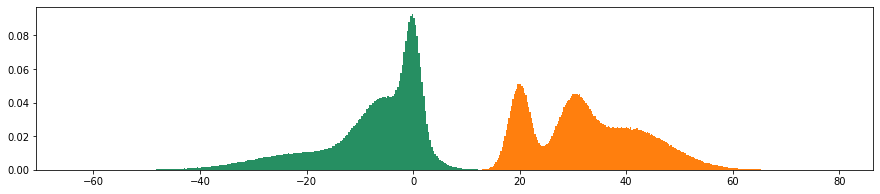

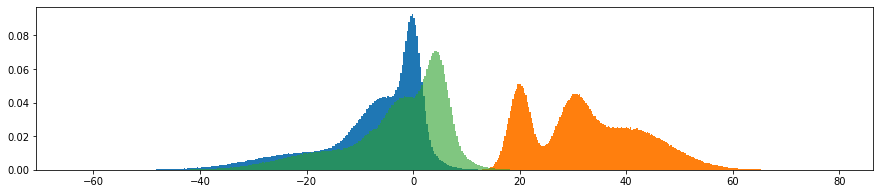

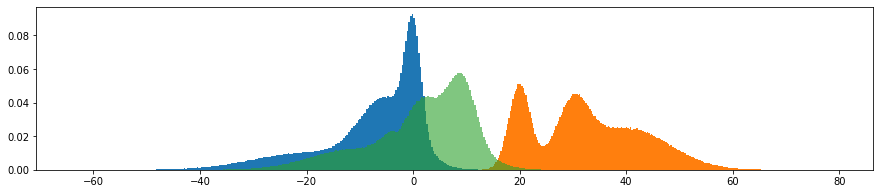

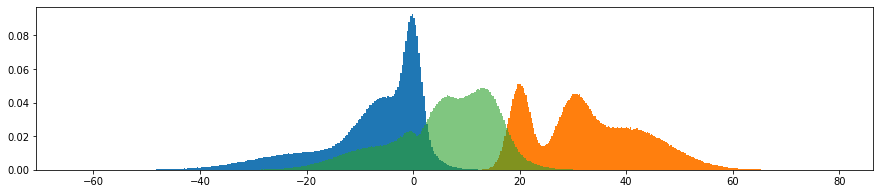

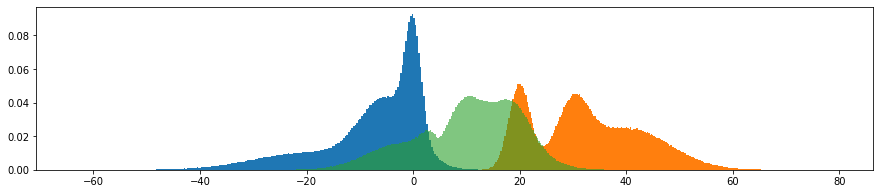

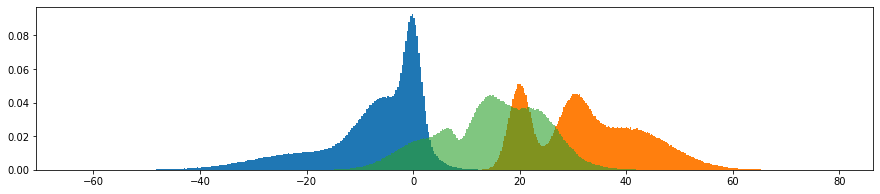

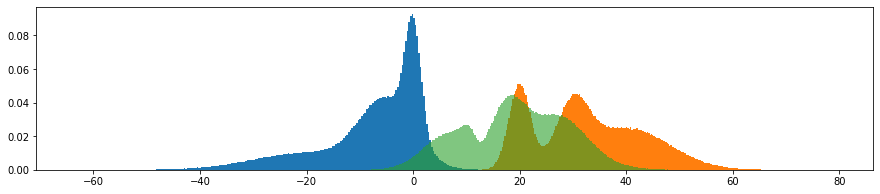

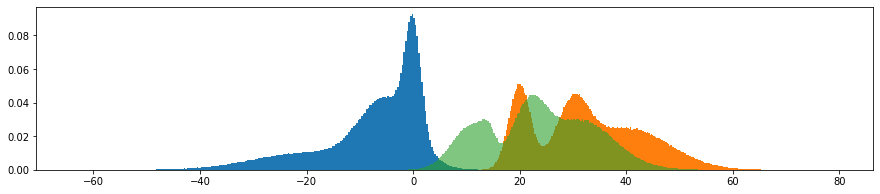

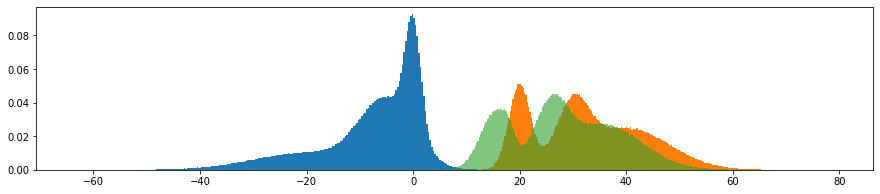

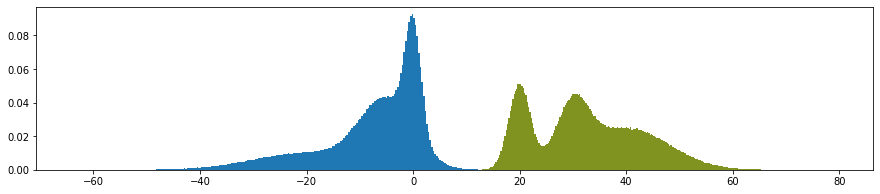

In [58]:
for t in np.linspace(0,1,10):
    Z = (1-t)*X + t*Y:  ((1-t)P1 =-  )_{#}Gamma
    plt.figure(figsize=(15,3))
    plt.hist(X, bins=300, density=True);
    plt.hist(Y, bins=300, density=True);
    plt.hist(Z, bins=300, density=True, alpha=0.6);
    plt.show()